In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/var/folders/27/3yxrjnr94l12ymwg7m474pph0000gn/T/ipykernel_38795/883015914.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DNS30 = pd.read_csv('DNS30_calibrated_yield_curves_202303_regulation.csv', parse_dates=['Date']).set_index('Date').sort_index()


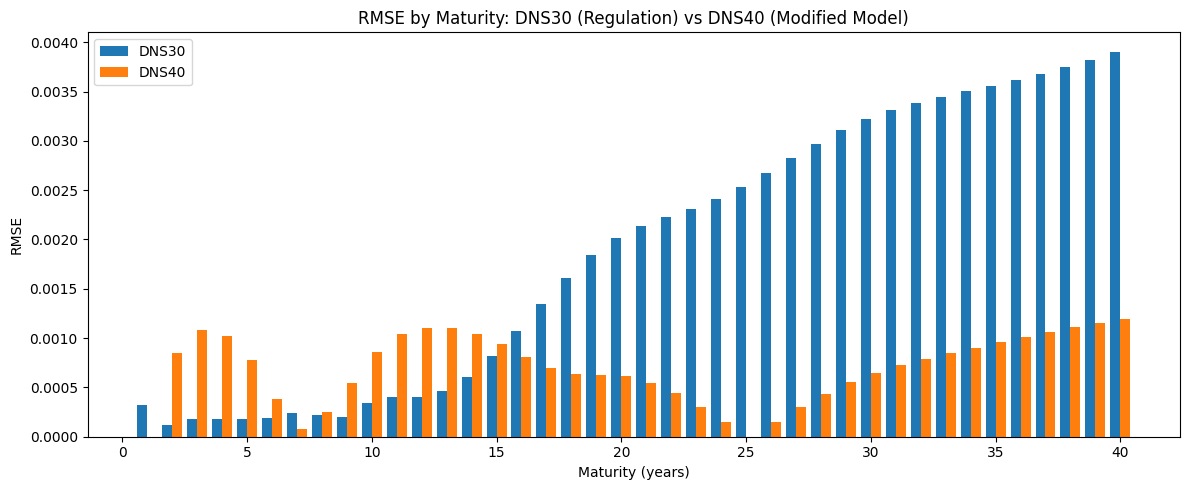

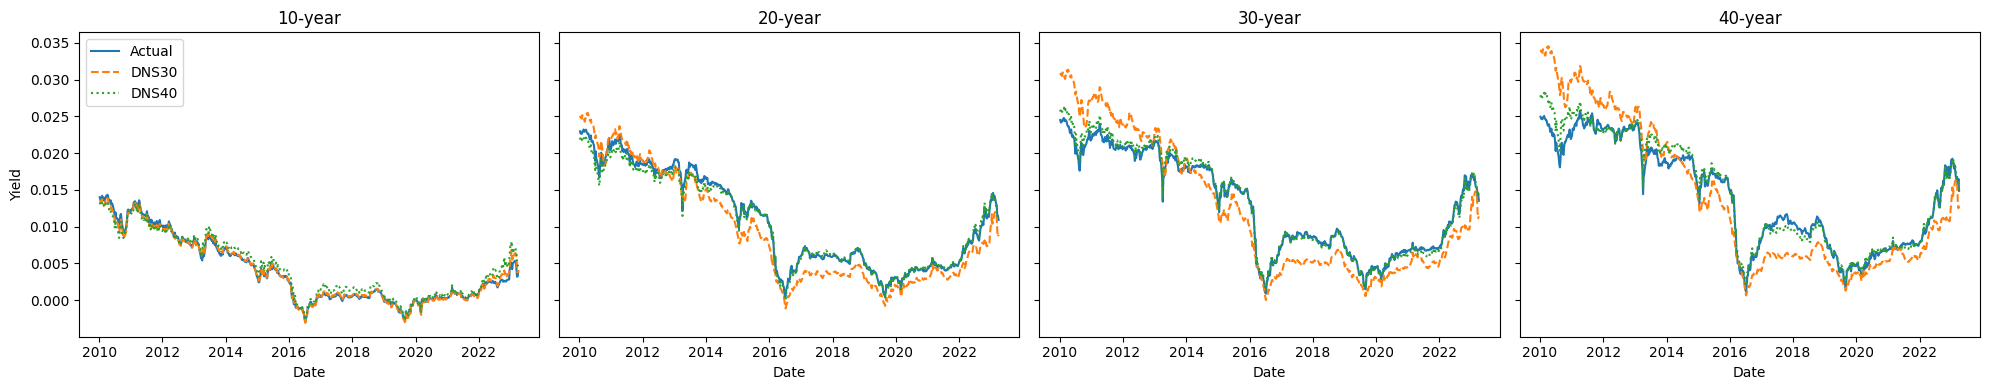

In [4]:
DNS30 = pd.read_csv('DNS30_calibrated_yield_curves_202303_regulation.csv', parse_dates=['Date']).set_index('Date').sort_index()
DNS40 = pd.read_csv('DNS40_calibrated_yield_curves_202303.csv', parse_dates=['Date']).set_index('Date').sort_index()
actual = pd.read_csv('daily_smith_wilson_20000101_.csv', parse_dates=['Date']).set_index('Date').sort_index()

# --- RMSE---
def compute_rmse(df_model, df_actual, start, end, max_mat=40):
    cols = [str(i) for i in range(1, max_mat+1)]
    m_act = df_actual.loc[start:end, cols].astype(float)
    m_mod = df_model .loc[start:end, cols].astype(float)
    m_act, m_mod = m_act.align(m_mod, join='inner', axis=0)
    return np.sqrt(((m_mod - m_act)**2).mean(axis=0))

rmse30 = compute_rmse(DNS30, actual, '2010-01-01', '2023-03-31')
rmse40 = compute_rmse(DNS40, actual, '2010-01-01', '2023-03-31')
rmse_df = pd.DataFrame({'Maturity': rmse30.index.astype(int), 'DNS30': rmse30.values, 'DNS40': rmse40.values})

plt.figure(figsize=(12, 5))
x = rmse_df['Maturity']
w = 0.4
plt.bar(x - w/2, rmse_df['DNS30'], width=w, label='DNS30')
plt.bar(x + w/2, rmse_df['DNS40'], width=w, label='DNS40')
plt.xlabel('Maturity (years)')
plt.ylabel('RMSE')
plt.title('RMSE by Maturity: DNS30 (Regulation) vs DNS40 (Modified Model)')
plt.legend()
plt.tight_layout()
plt.show()

# --- Yield Curve Plot ---
def plot_yield(maturities, start, end):
    fig, axes = plt.subplots(1, 4, figsize=(20, 4), sharex=True, sharey=True)
    for ax, mat in zip(axes, maturities):
        c = str(mat)
        s_act   = actual[c] if c in actual.columns else pd.Series(dtype=float)
        s_dns30 = DNS30[c]   if c in DNS30.columns   else pd.Series(dtype=float)
        s_dns40 = DNS40[c]   if c in DNS40.columns   else pd.Series(dtype=float)
        df = pd.concat([s_act, s_dns30, s_dns40], axis=1, keys=['Actual','DNS30','DNS40']).dropna().loc[start:end]
        
        ax.plot(df.index, df['Actual'],  '-', label='Actual')
        ax.plot(df.index, df['DNS30'],  '--', label='DNS30')
        ax.plot(df.index, df['DNS40'],  ':', label='DNS40')
        ax.set_title(f'{mat}-year')
        ax.set_xlabel('Date')
    
    axes[0].set_ylabel('Yield')
    
    axes[0].legend(loc='upper left')
    plt.tight_layout()
    plt.show()

plot_yield([10,20,30,40], '2010-01-01', '2023-03-31')


/var/folders/27/3yxrjnr94l12ymwg7m474pph0000gn/T/ipykernel_51001/960722040.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DNS30 = pd.read_csv('DNS30_calibrated_yield_curves_202303_regulation.csv', parse_dates=['Date']).set_index('Date').sort_index()
/var/folders/27/3yxrjnr94l12ymwg7m474pph0000gn/T/ipykernel_51001/960722040.py:9: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  gp_mean_shifted.index = gp_mean_shifted.index + pd.DateOffset(month=1)


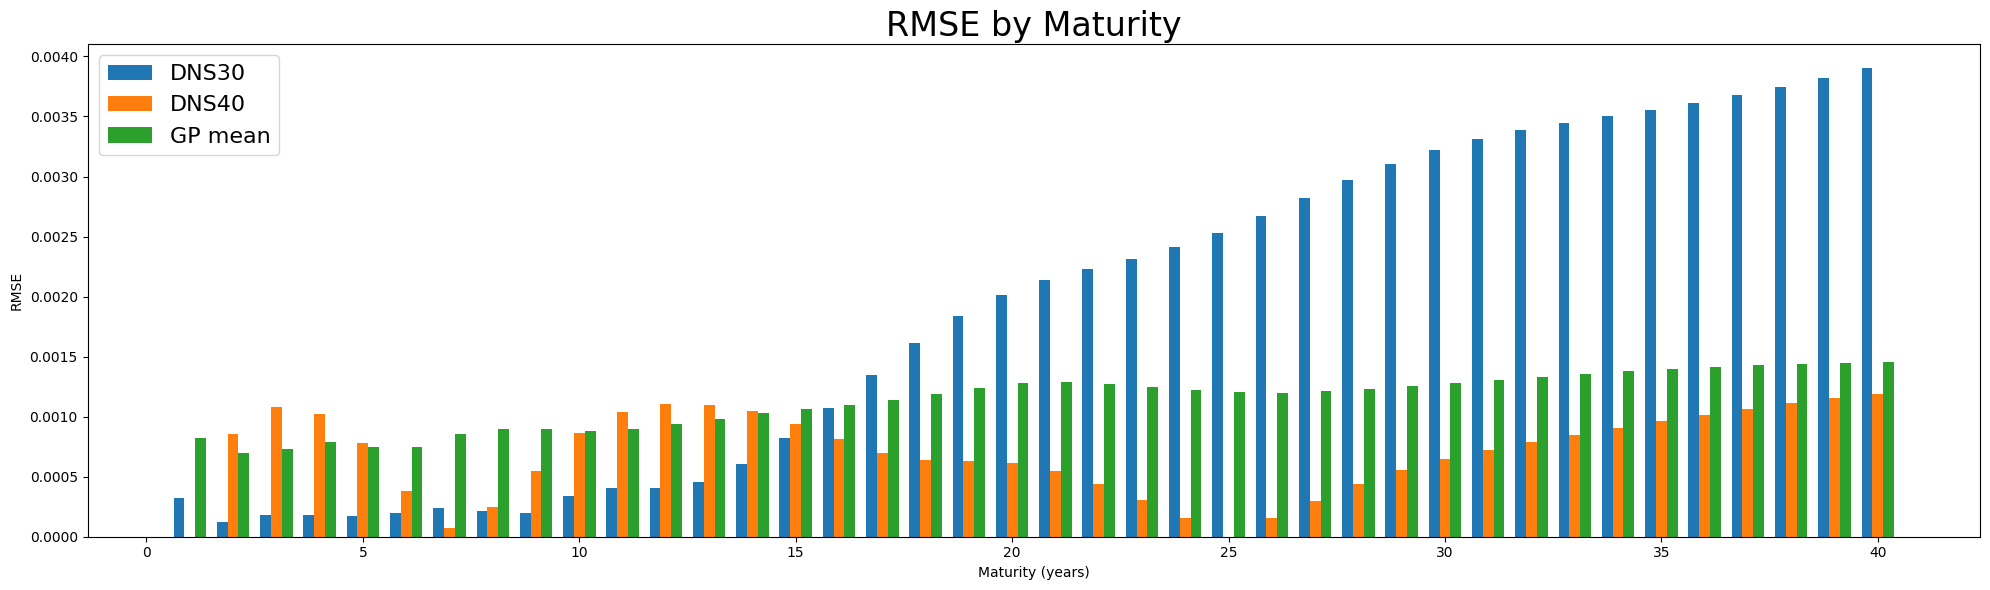

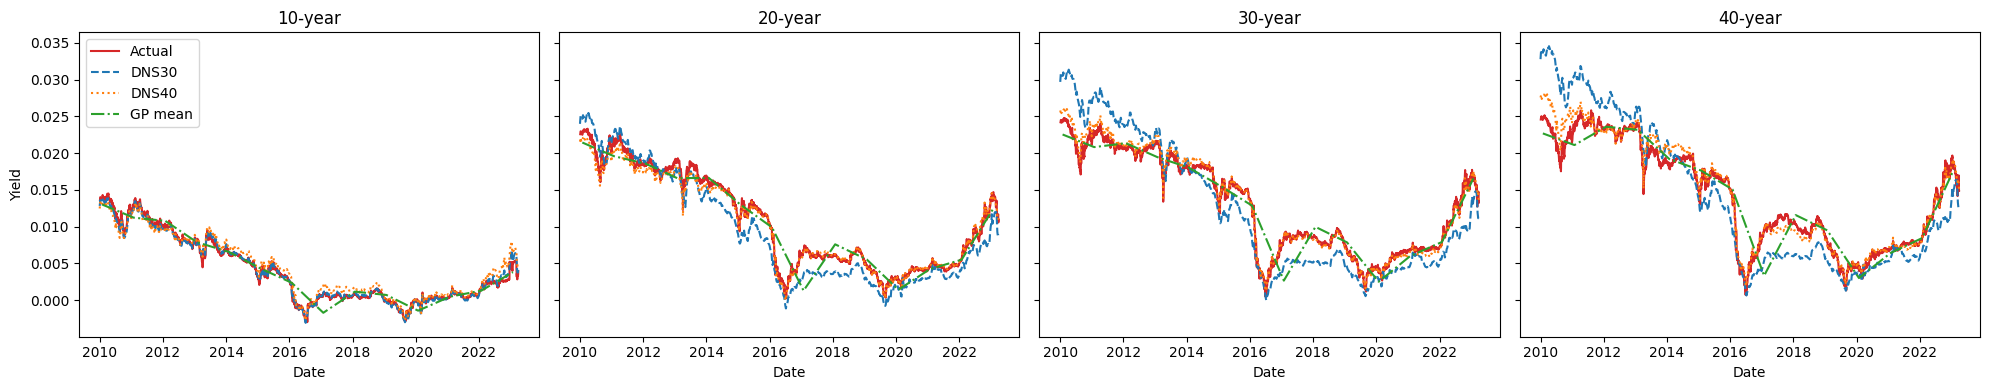

In [ ]:
DNS30 = pd.read_csv('DNS30_calibrated_yield_curves_202303_regulation.csv', parse_dates=['Date']).set_index('Date').sort_index()
DNS40 = pd.read_csv('DNS40_calibrated_yield_curves_202303.csv', parse_dates=['Date']).set_index('Date').sort_index()
actual = pd.read_csv('daily_smith_wilson_20000101_.csv', parse_dates=['Date']).set_index('Date').sort_index()

gp = pd.read_csv('DGP_IR_scenarios_1-year_v3.3.3c.csv', parse_dates=['date']).rename(columns={'date':'Date'})
gp_mean = gp.drop(columns='sim_id').groupby('Date').mean().sort_index()
# 1 year shift to align the date
gp_mean_shifted = gp_mean.copy()
gp_mean_shifted.index = gp_mean_shifted.index + pd.DateOffset(month=1)

# ---RMSE---
def compute_rmse_multi(models: dict, df_actual, start, end, max_mat=40):
    cols = [str(i) for i in range(1, max_mat+1)]
    m_act = df_actual.loc[start:end, cols].astype(float)
    rmses = {}
    for name, df_mod in models.items():
        m_mod = df_mod.loc[start:end, cols].astype(float)
        m_act_a, m_mod_a = m_act.align(m_mod, join='inner', axis=0)
        rmses[name] = np.sqrt(((m_mod_a - m_act_a)**2).mean(axis=0))
    return pd.DataFrame(rmses)


models = {'DNS30': DNS30, 'DNS40': DNS40, 'GP_mean': gp_mean_shifted}

rmse_df = compute_rmse_multi(models, actual, '2010-01-01', '2023-03-31', max_mat=40)
rmse_df.index = rmse_df.index.astype(int)


colors = {
    'DNS30':  'tab:blue',
    'DNS40':  'tab:orange',
    'GP_mean':'tab:green',
    'Actual': 'tab:red'
}

plt.figure(figsize=(20,6))
x = rmse_df.index.values
width = 0.25

plt.bar(x - width, rmse_df['DNS30'],    width=width, label='DNS30',    color=colors['DNS30'])
plt.bar(x,       rmse_df['DNS40'],    width=width, label='DNS40',    color=colors['DNS40'])
plt.bar(x + width, rmse_df['GP_mean'], width=width, label='GP mean',  color=colors['GP_mean'])

plt.xlabel('Maturity (years)')
plt.ylabel('RMSE')
plt.title('RMSE by Maturity',fontsize=24)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()


def plot_yield_subplots_independent(models, maturities, start, end, colors):
    fig, axes = plt.subplots(1, len(maturities), figsize=(5*len(maturities),4), sharex=True, sharey=True)
    for ax, mat in zip(axes, maturities):
        col = str(mat)
        if col in actual.columns:
            s = actual[col].loc[start:end]
            ax.plot(s.index, s.values, '-', label='Actual', color=colors['Actual'])
        if col in DNS30.columns:
            s = DNS30[col].loc[start:end]
            ax.plot(s.index, s.values, '--', label='DNS30', color=colors['DNS30'])
        if col in DNS40.columns:
            s = DNS40[col].loc[start:end]
            ax.plot(s.index, s.values, ':', label='DNS40', color=colors['DNS40'])
        if col in gp_mean_shifted.columns:
            s = gp_mean_shifted[col].loc[start:end]
            ax.plot(s.index, s.values, '-.', label='GP mean', color=colors['GP_mean'])
        ax.set_title(f'{mat}-year')
        ax.set_xlabel('Date')
    axes[0].set_ylabel('Yield')
    axes[0].legend(loc='upper left')
    plt.tight_layout()
    plt.show()

plot_yield_subplots_independent(models, [10,20,30,40], '2010-01-01', '2023-03-31', colors)

/var/folders/27/3yxrjnr94l12ymwg7m474pph0000gn/T/ipykernel_21785/3669613049.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  DNS30 = pd.read_csv('DNS30_calibrated_yield_curves_202203_regulation.csv', parse_dates=['Date']).set_index('Date').sort_index()


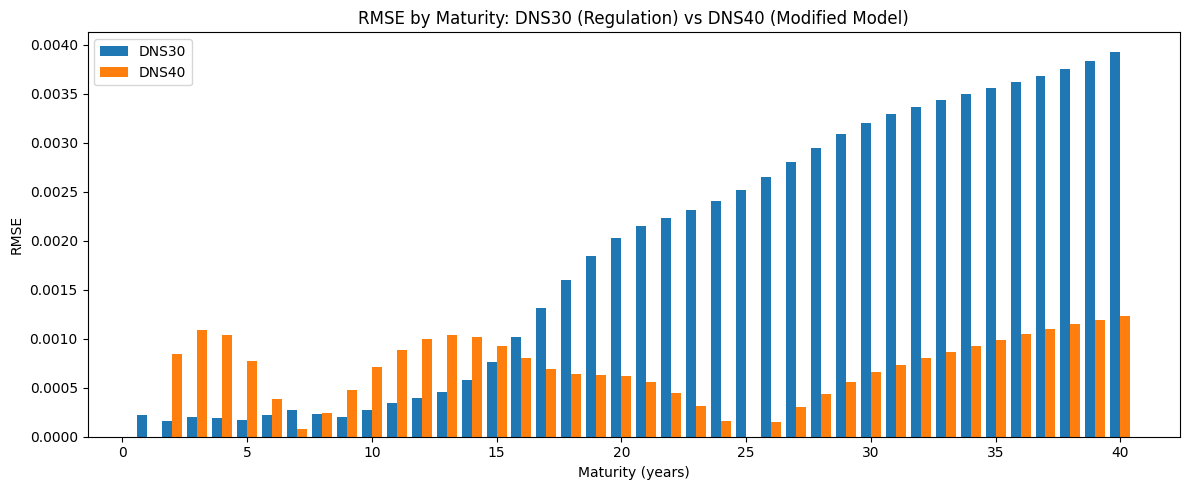

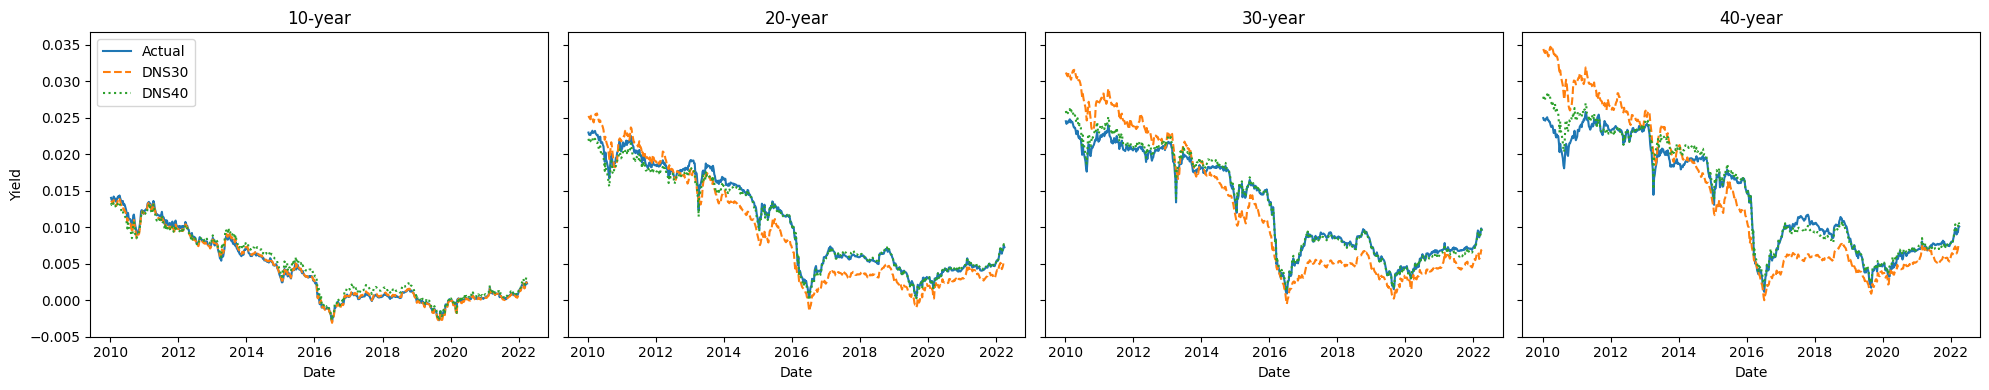

In [3]:
DNS30 = pd.read_csv('DNS30_calibrated_yield_curves_202203_regulation.csv', parse_dates=['Date']).set_index('Date').sort_index()
DNS40 = pd.read_csv('DNS40_calibrated_yield_curves_202203.csv', parse_dates=['Date']).set_index('Date').sort_index()
actual = pd.read_csv('daily_smith_wilson_20000101_.csv', parse_dates=['Date']).set_index('Date').sort_index()

# --- RMSE---
def compute_rmse(df_model, df_actual, start, end, max_mat=40):
    cols = [str(i) for i in range(1, max_mat+1)]
    m_act = df_actual.loc[start:end, cols].astype(float)
    m_mod = df_model .loc[start:end, cols].astype(float)
    m_act, m_mod = m_act.align(m_mod, join='inner', axis=0)
    return np.sqrt(((m_mod - m_act)**2).mean(axis=0))

rmse30 = compute_rmse(DNS30, actual, '2010-01-01', '2023-03-31')
rmse40 = compute_rmse(DNS40, actual, '2010-01-01', '2023-03-31')
rmse_df = pd.DataFrame({'Maturity': rmse30.index.astype(int), 'DNS30': rmse30.values, 'DNS40': rmse40.values})

plt.figure(figsize=(12, 5))
x = rmse_df['Maturity']
w = 0.4
plt.bar(x - w/2, rmse_df['DNS30'], width=w, label='DNS30')
plt.bar(x + w/2, rmse_df['DNS40'], width=w, label='DNS40')
plt.xlabel('Maturity (years)')
plt.ylabel('RMSE')
plt.title('RMSE by Maturity: DNS30 (Regulation) vs DNS40 (Modified Model)')
plt.legend()
plt.tight_layout()
plt.show()

# --- Yield Curve Plot ---
def plot_yield(maturities, start, end):
    fig, axes = plt.subplots(1, 4, figsize=(20, 4), sharex=True, sharey=True)
    for ax, mat in zip(axes, maturities):
        c = str(mat)
        s_act   = actual[c] if c in actual.columns else pd.Series(dtype=float)
        s_dns30 = DNS30[c]   if c in DNS30.columns   else pd.Series(dtype=float)
        s_dns40 = DNS40[c]   if c in DNS40.columns   else pd.Series(dtype=float)
        df = pd.concat([s_act, s_dns30, s_dns40], axis=1, keys=['Actual','DNS30','DNS40']).dropna().loc[start:end]
        
        ax.plot(df.index, df['Actual'],  '-', label='Actual')
        ax.plot(df.index, df['DNS30'],  '--', label='DNS30')
        ax.plot(df.index, df['DNS40'],  ':', label='DNS40')
        ax.set_title(f'{mat}-year')
        ax.set_xlabel('Date')
    
    axes[0].set_ylabel('Yield')
    
    axes[0].legend(loc='upper left')
    plt.tight_layout()
    plt.show()

plot_yield([10,20,30,40], '2010-01-01', '2023-03-31')
